## Import here all the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
import random
from keras.utils import np_utils
from scipy.stats import multivariate_normal as mvn
from keras.callbacks import TensorBoard

import string
import re #regular expressions
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from __future__ import absolute_import, division, print_function, unicode_literals
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import regularizers

#Import .py file of general algorithms
from google.colab import files
#files.upload()
from general import accuracy, R2, OLS
from general import confusionMatrix
from general import SimpleLogisticRegression, ANN
from general import derivative, relu, linear, sigmoid, softmax, bin_cross_entropy, one_hot

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#Mount Google Drive Folders
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load dataset

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Datos/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Datos/test.csv')
dev = pd.read_csv('/content/drive/MyDrive/Datos/dev.csv')
train.head()

,Utterance,Dialogue_Act,Emotion,Dialogue_ID
0,"say , jim , how about going for a few beers af...",directive,no emotion,1
1,you know that is tempting but is really not go...,commissive,no emotion,1
2,what do you mean ? it will help us to relax .,question,no emotion,1
3,do you really think so ? i don't . it will jus...,question,no emotion,1
4,i guess you are right.but what shall we do ? i...,question,no emotion,1


In [ ]:
def trans_y(x):
  if x == 'directive' or x == 'commissive':
    return 0
  elif x == 'inform':
    return 1
  elif x == 'question':
    return 2

train.Dialogue_Act = train.	Dialogue_Act.apply(trans_y)
test.Dialogue_Act = test.	Dialogue_Act.apply(trans_y)
dev.Dialogue_Act = dev.	Dialogue_Act.apply(trans_y)
train.head()

,Utterance,Dialogue_Act,Emotion,Dialogue_ID
0,"say , jim , how about going for a few beers af...",0,no emotion,1
1,you know that is tempting but is really not go...,0,no emotion,1
2,what do you mean ? it will help us to relax .,2,no emotion,1
3,do you really think so ? i don't . it will jus...,2,no emotion,1
4,i guess you are right.but what shall we do ? i...,2,no emotion,1


In [ ]:
train.drop(['Emotion','Dialogue_ID'], inplace = True, axis = 1)
test.drop(['Emotion','Dialogue_ID'], inplace = True, axis = 1)
dev.drop(['Emotion','Dialogue_ID'], inplace = True, axis = 1)
train.head()

,Utterance,Dialogue_Act
0,"say , jim , how about going for a few beers af...",0
1,you know that is tempting but is really not go...,0
2,what do you mean ? it will help us to relax .,2
3,do you really think so ? i don't . it will jus...,2
4,i guess you are right.but what shall we do ? i...,2


In [ ]:
#Check the size of the data
print(f"Size of dataset: {train.shape}")

#Check and delete for duplicates
print(f"Number of duplicate rows: {train[train.duplicated()].shape}\n")
train.drop_duplicates(subset=None, keep="first", inplace=True)
print(f"Final size of dataset: {train.shape}")

train = train.reset_index()

Size of dataset: (87170, 2)
Number of duplicate rows: (14779, 2)

Final size of dataset: (72391, 2)


## Data Preprocessing

In [ ]:
def preprocess(sentence,lemma=True):
  #Remove url links
  proc_sent = re.sub(r'https?:\/\/.*[\r\n]*','',sentence)

  #Delete non-ASCII values
  proc_sent = str(proc_sent.encode("ascii","ignore"))[1:]

  #Remove punctuation
  proc_sent = ''.join([char for char in proc_sent if char not in string.punctuation])

  #Parse to lower case
  proc_sent = proc_sent.lower()

  #Tokenize and remove stop words
  stop_words = stopwords.words('english')
  proc_sent = word_tokenize(proc_sent)
  #proc_sent = [word for word in proc_sent if word not in stop_words]

  #Remove single letters
  proc_sent = [word for word in proc_sent if len(word) != 1]

  #Stem or lemmatize (just 1)
  if lemma:
    lemmatizer = WordNetLemmatizer()
    proc_sent = [lemmatizer.lemmatize(word) for word in proc_sent]
  else:
    porter = PorterStemmer()
    proc_sent = [porter.stem(word) for word in proc_sent] #Stemming

  return proc_sent

In [ ]:
train.Utterance = train.Utterance.apply(preprocess)
test.Utterance = test.Utterance.apply(preprocess)
dev.Utterance = dev.Utterance.apply(preprocess)
print(f"{len(train)} observations...")

72391 observations...


Text(0.5, 1.0, 'Sentences by class')

<Figure size 432x288 with 0 Axes>

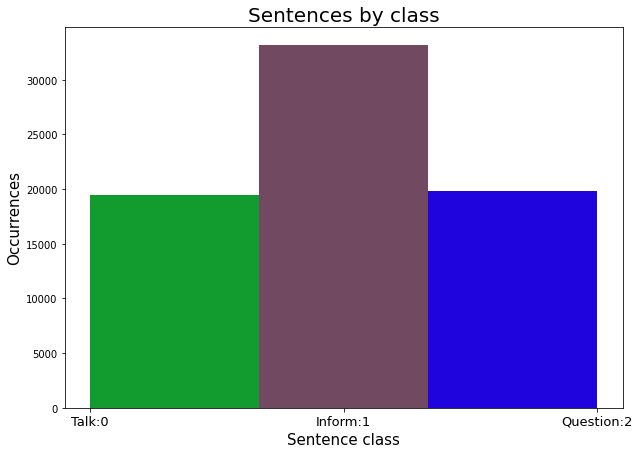

In [ ]:
plt.figure()
fig, ax = plt.subplots(figsize=(10,7))
N, bins, patches = plt.hist(train['Dialogue_Act'], bins=3)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Talk:0','Inform:1','Question:2'], size=13)
for i in range(len(N)):
  patches[i].set_facecolor("#" + ''.join(random.choices("ABCDEF" + string.digits, k=6)))

plt.ylabel("Occurrences", size=15)
plt.xlabel("Sentence class", size=15)
plt.title("Sentences by class", size=20)

Text(0.5, 1.0, "Analysis of sentence's length")

<Figure size 432x288 with 0 Axes>

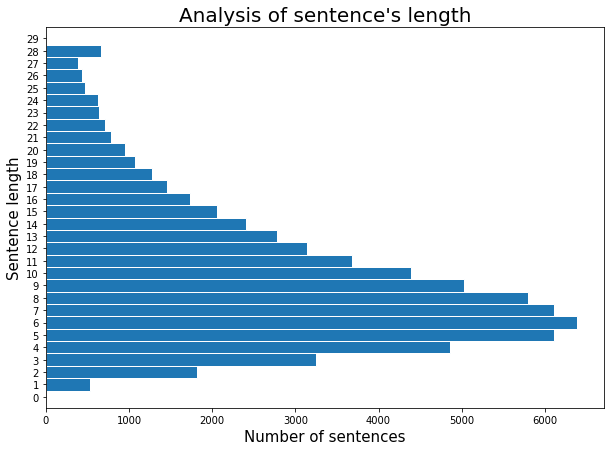

In [ ]:
lengths = [len(i) for i in train['Utterance']]
uniques = np.unique(lengths)
bins = [i for i in range(1,30)]

plt.figure()
fig, ax = plt.subplots(figsize=(10,7))
N, bins, patches = plt.hist(lengths, bins=bins, orientation='horizontal', edgecolor='white', linewidth=1, align='left')
ax.set_yticks(np.arange(30))
ax.set_yticklabels(uniques, size=10)
#for i in range(len(N)):
#  patches[i].set_facecolor("#" + ''.join(random.choices("ABCDEF" + string.digits, k=6)))
#patches.set_facecolor(, k = 10)

plt.ylabel("Sentence length", size=15)
plt.xlabel("Number of sentences", size=15)
plt.title("Analysis of sentence's length", size=20)

In [ ]:
#Remove short sentences
#size = int(np.mean(np.arange(1,25)))

#for i in range(len(train['Utterance'])):
  #Save as is if the size is between the margins
  #Clip the long sentences to make them shorter
#  if len(train['Utterance'][i]) > 25:
#    train['Utterance'][i] = train['Utterance'][i][:size]
#  elif len(train['Utterance'][i]) < 1:
#    train.drop([i], axis=0, inplace=True)

#train = train.reset_index()
#print(f"{len(train)} observations...")
#print(f"Mean size for clipping sentences: {size}")

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  83  84  85  86  87  88  89  90
  91  92  94  95  97  98  99 100 109 110 111 114 116 119 121 123 129 146
 199 201 239]


Text(0.5, 1.0, 'Analysis of stemmed sentences')

<Figure size 432x288 with 0 Axes>

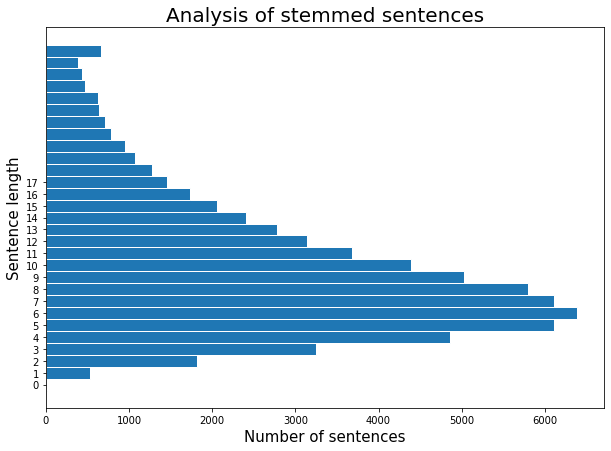

In [ ]:
lengths = [len(i) for i in train['Utterance']]
uniques = np.unique(lengths)
print(uniques)
bins = [i for i in range(30)]

plt.figure()
fig, ax = plt.subplots(figsize=(10,7))
N, bins, patches = plt.hist(lengths, bins=bins, orientation='horizontal', edgecolor='white', linewidth=1, align='left')
ax.set_yticks(np.arange(18))
#for i in range(len(N)):
#  patches[i].set_facecolor("#" + ''.join(random.choices("ABCDEF" + string.digits, k=6)))

plt.ylabel("Sentence length", size=15)
plt.xlabel("Number of sentences", size=15)
plt.title("Analysis of stemmed sentences", size=20)

In [ ]:
def pd_to_tensor_data (data):
  new_tensor_data = tf.data.Dataset.from_tensor_slices(
    (
        tf.cast(data["Utterance"].values, tf.string),
        tf.cast(data["Dialogue_Act"].values, tf.int64)
        )
  )
  return new_tensor_data

In [ ]:
def join_text (text):
  return " ".join(text)

In [ ]:
train['Utterance'] = train['Utterance'].apply(join_text)
test['Utterance'] = test['Utterance'].apply(join_text)
dev['Utterance'] = dev['Utterance'].apply(join_text)
train.drop(['index'], inplace=True, axis=1)
train

,Utterance,Dialogue_Act
0,say jim how about going for few beer after dinner,0
1,you know that is tempting but is really not go...,0
2,what do you mean it will help u to relax,2
3,do you really think so dont it will just make ...,2
4,guess you are rightbut what shall we do dont f...,2
...,...,...
72386,want pair of locus,0
72387,take look at the one on display please,0
72388,need size 41,0
72389,could have the check please,0


Make the training, validation, and test sets

In [ ]:
print(f"Training set: {train.shape}")
print(f"Validation set: {dev.shape}")
print(f"Test set: {test.shape}")

Training set: (72391, 2)
Validation set: (8069, 2)
Test set: (7740, 2)


In [ ]:
tensor_train = pd_to_tensor_data(train)
tensor_validation = pd_to_tensor_data(dev)
tensor_test = pd_to_tensor_data(test)

In [ ]:
tensor_train

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Model Creation

Create the embeddings

In [ ]:
#embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1" #El mejor
#embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
#embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
#embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'
#embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
#embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
hub_layer = hub.KerasLayer(embedding,
                           input_shape=[],
                           dtype=tf.string,
                           trainable=True)

In [ ]:
model = keras.Sequential()
model.add(hub_layer)  #Embedding layer
model.add(keras.layers.Dense(4, activation='relu',  kernel_regularizer = regularizers.L1(0.005)))
#model.add(keras.layers.Dense(3, activation='relu',  kernel_regularizer = regularizers.L1(0.01)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 4)                 204       
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 3)                 15        
                                                                 
Total params: 48,190,819
Trainable params: 48,190,819
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'Adam',
              loss = keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(tensor_train.batch(512),
                    epochs = 20,
                    validation_data = tensor_validation.batch(512))
#                    verbose = 2)

Epoch 1/20
142/142 [==============================] - 81s 562ms/step - loss: 1.1482 - accuracy: 0.4834 - val_loss: 1.0462 - val_accuracy: 0.5768
Epoch 2/20
142/142 [==============================] - 77s 544ms/step - loss: 0.9905 - accuracy: 0.5761 - val_loss: 0.9304 - val_accuracy: 0.6729
Epoch 3/20
142/142 [==============================] - 77s 540ms/step - loss: 0.9134 - accuracy: 0.6125 - val_loss: 0.8592 - val_accuracy: 0.6920
Epoch 4/20
142/142 [==============================] - 78s 546ms/step - loss: 0.8727 - accuracy: 0.6239 - val_loss: 0.8239 - val_accuracy: 0.6975
Epoch 5/20
142/142 [==============================] - 76s 537ms/step - loss: 0.8459 - accuracy: 0.6330 - val_loss: 0.8017 - val_accuracy: 0.6987
Epoch 6/20
142/142 [==============================] - 76s 534ms/step - loss: 0.8278 - accuracy: 0.6384 - val_loss: 0.7873 - val_accuracy: 0.7023
Epoch 7/20
142/142 [==============================] - 77s 541ms/step - loss: 0.8148 - accuracy: 0.6434 - val_loss: 0.7755 - val_ac

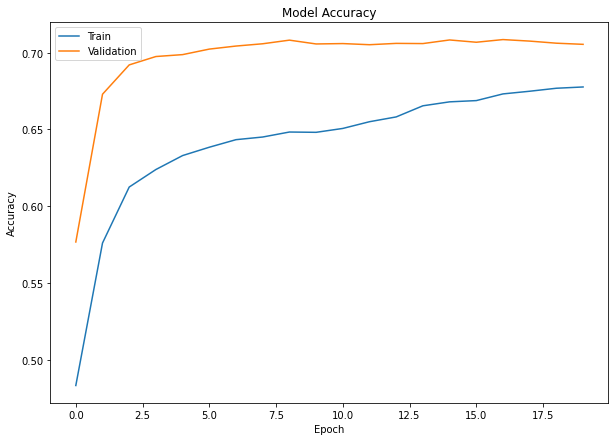

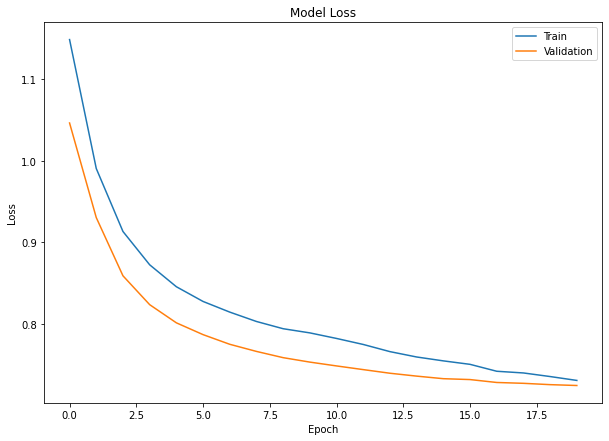

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(10,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

https://huggingface.co/datasets/silicone

https://huggingface.co/datasets/silicone/tree/main/dummy/dyda_da/1.0.0

In [ ]:
yhat = model.predict(np.array(test.Utterance))

In [ ]:
y2hat = np.argmax(yhat, axis = 1)

In [ ]:
accuracy(test.Dialogue_Act,y2hat)

0.7308785529715762

Text(0.5, 12.5, 'Predicted label')

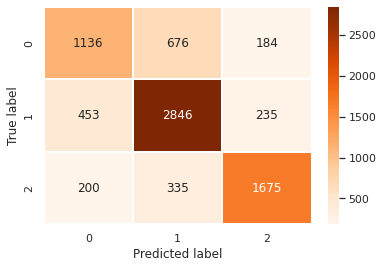

In [ ]:
cm = pd.crosstab(test.Dialogue_Act,y2hat)
sns.set(font_scale = 1)
ax = sns.heatmap(cm, annot=True, cmap='Oranges',  fmt='d', linewidths=1)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
model.get_weights()

[array([[-0.07078403,  0.2309921 , -0.04001201, ...,  0.006042  ,
          0.01584901, -0.23308909],
        [ 0.13103518,  0.17923635,  0.01063039, ..., -0.29381433,
          0.05539819,  0.05226879],
        [ 0.06475412, -0.12864912, -0.12485643, ..., -0.16776969,
          0.07435564,  0.19124678],
        ...,
        [ 0.4045343 , -0.17706504, -0.13003995, ..., -0.01742322,
          0.02578888,  0.29181632],
        [ 0.4186347 ,  0.0406054 , -0.14481059, ..., -0.05217805,
          0.03594268,  0.21899657],
        [ 0.53632677, -0.06234785, -0.07169826, ...,  0.11806542,
         -0.06521951,  0.25392768]], dtype=float32),
 array([[-8.64409842e-03, -1.35629415e-03,  2.39973539e-04,
          2.63674883e-06],
        [ 2.65687108e-01, -4.65952908e-05, -1.28384598e-03,
         -2.98594922e-01],
        [-1.01601596e-04,  1.22161724e-01,  3.96659103e-04,
          1.58998650e-04],
        [ 1.07205147e-03,  2.53814667e-01, -7.08013475e-02,
         -4.48130444e-03],
        [-

## Model implementation